In [55]:
import numpy as np
import pandas as pd
from scipy.ndimage import label 
import matplotlib.pyplot as plt

def get_object_count_per_size(grid):
    object_count_per_size = {}

    for value in range(1, 10):
        mask = (grid == value)
        labeled, num_features = label(mask)
        
        sizes = [np.sum(labeled == i) for i in range(1, num_features + 1)]
        for size in sizes:
            object_count_per_size[size] = object_count_per_size.get(size, 0) + 1
    
    return object_count_per_size

def flatten_area_counts(area_counts):
    """Convert {area: count} into [area] * count"""
    return [area for area, count in area_counts.items() for _ in range(count)]

def get_aggregates(pairs):
    all_areas = []
    total_objects = 0
    for inp, out in pairs:
        for grid in (inp, out):
            area_counts = get_object_count_per_size(grid)
            flattened = flatten_area_counts(area_counts)
            all_areas.extend(flattened)
            total_objects += sum(area_counts.values())
    
    avg_objects_per_grid = total_objects / (2 * len(pairs)) if pairs else 0
    avg_area = np.mean(all_areas) if all_areas else 0

    return {
        'total_objects': total_objects,
        'avg_objects_per_grid': avg_objects_per_grid,
        'avg_object_size': avg_area,
    }

def get_task_stats(task):
    train_pairs = task['train']
    test_pairs = task['test']
    pairs = train_pairs + test_pairs

    stats = get_aggregates(pairs)

    return stats

In [56]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from models.pipeline import Pipeline
from utils.view import draw_grid

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v2_vampprior import ConvolutionalVAEV2_VampPrior
from models.convolutional_vae_v2_vampprior import preprocess_grid as preprocess_grid_vp, postprocess_grid as postprocess_grid_vp
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=512,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_512_b01.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [ ]:
model = ConvolutionalVAEV3(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=256,
    feature_dim=[4, 4]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev3_256_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev3,
    postprocess_fn=postprocess_vaev3,
)
model_type = "vae"

In [ ]:
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=256,
    embedding_dim=128,
    commitment_cost=0.25
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vqvae_6x6x128_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [ ]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/vq_vae_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:
n_components = 256

# input_dim = n_components
input_dim = 128
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/ppca128_vae_64_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [39]:
def reconstruct_grid(grid, expected_grid, model_type):
    grid = pipeline.preprocess_and_compress(grid)
    
    grid = grid.unsqueeze(0)
    grid_decoded = grid

    if model_type == 'vq':
        z_e = pipeline.encode(grid)
        z_q, _, _ = pipeline.model.quantize(z_e)
        grid_decoded = pipeline.decode(z_q)
    else:
        z, _ = pipeline.encode(grid)
        grid_decoded = pipeline.decode(z)

    grid_decoded = pipeline.decompress_and_postprocess(grid_decoded.squeeze(0), expected_grid)
    return grid_decoded

In [45]:
def reconstruct_data(data):
    return {
        puzzle_id: {
            split: [(reconstruct_grid(inp, inp, model_type), reconstruct_grid(out, out, model_type)) for inp, out in task.get(split, [])]
            for split in ['train', 'test']
        }
        for puzzle_id, task in data.items()
    }

rec_data = reconstruct_data(data)

In [ ]:
def build_task_stats_df(data):
    rows = []
    for puzzle_id, task in data.items():
        stats = get_task_stats(task)
        row = {
            'puzzle_id': puzzle_id,
            **stats
        }
        rows.append(row)
    return pd.DataFrame(rows)
    
def plot_original_vs_reconstructed(df_orig, df_recon, column_name):
    df_merged = df_orig[['puzzle_id', column_name]].merge(
    df_recon[['puzzle_id', column_name]],
    on='puzzle_id',
    suffixes=('_orig', '_recon')
)

    puzzles = df_merged['puzzle_id']
    x = np.arange(len(puzzles))
    orig_vals = df_merged[f'{column_name}_orig']
    recon_vals = df_merged[f'{column_name}_recon']
    width = 0.35

    _, ax = plt.subplots(figsize=(14, 7))
    ax.bar(x - width/2, orig_vals, width, label='Original')
    ax.bar(x + width/2, recon_vals, width, label='Reconstructed')

    column_title = column_name.replace('_', ' ').title()
    ax.set_ylabel(column_title)
    ax.set_title(f'{column_title} per Puzzle: Original vs Reconstructed')
    ax.set_xticks(x)
    ax.set_xticklabels([])  # Hide puzzle_id labels as you wanted
    ax.legend()

    plt.tight_layout()
    plt.show()

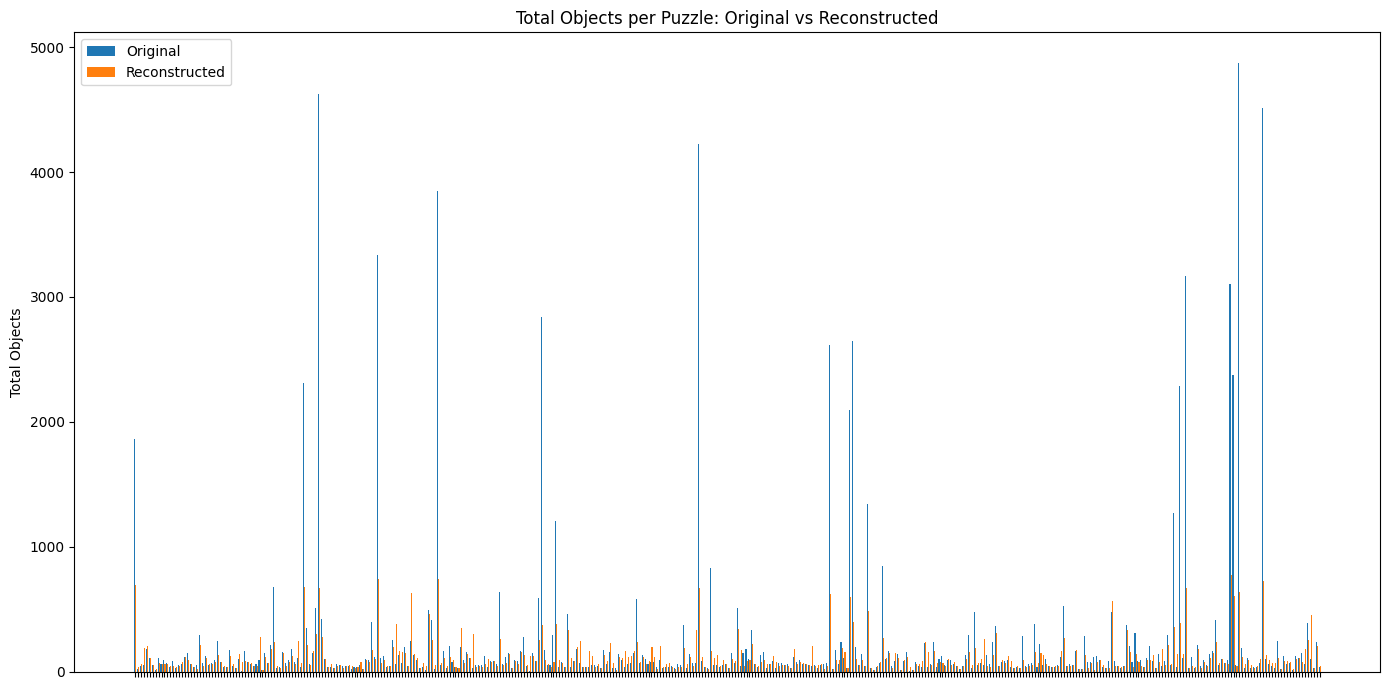

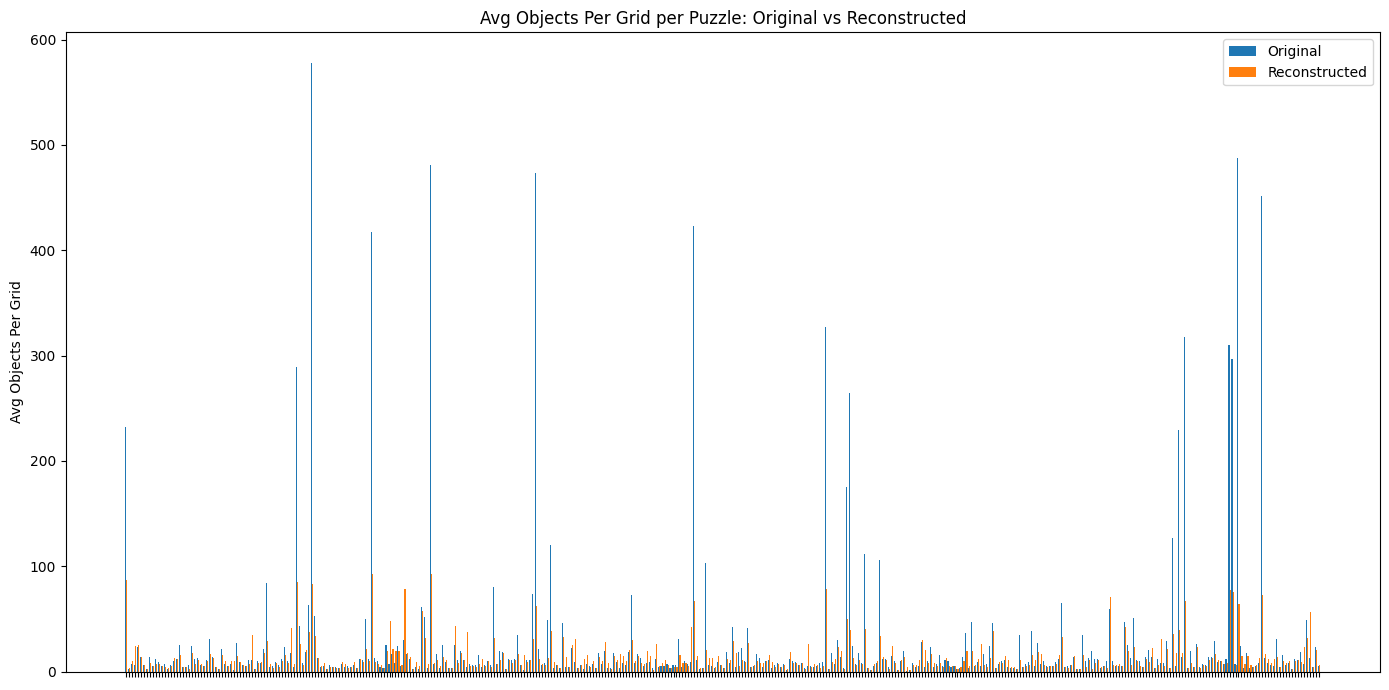

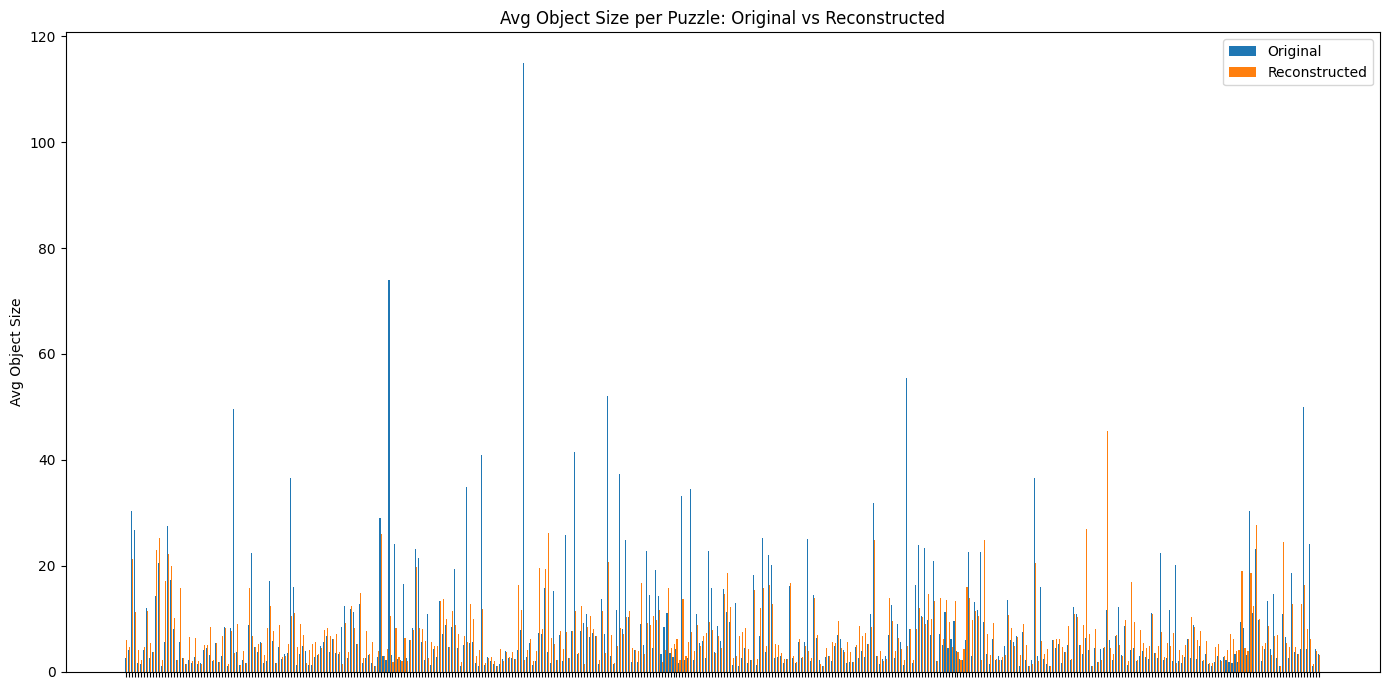

In [80]:
df = build_task_stats_df(data)
df_recon = build_task_stats_df(rec_data)

for col in df.columns:
    if col != 'puzzle_id':
        plot_original_vs_reconstructed(df, df_recon, col)

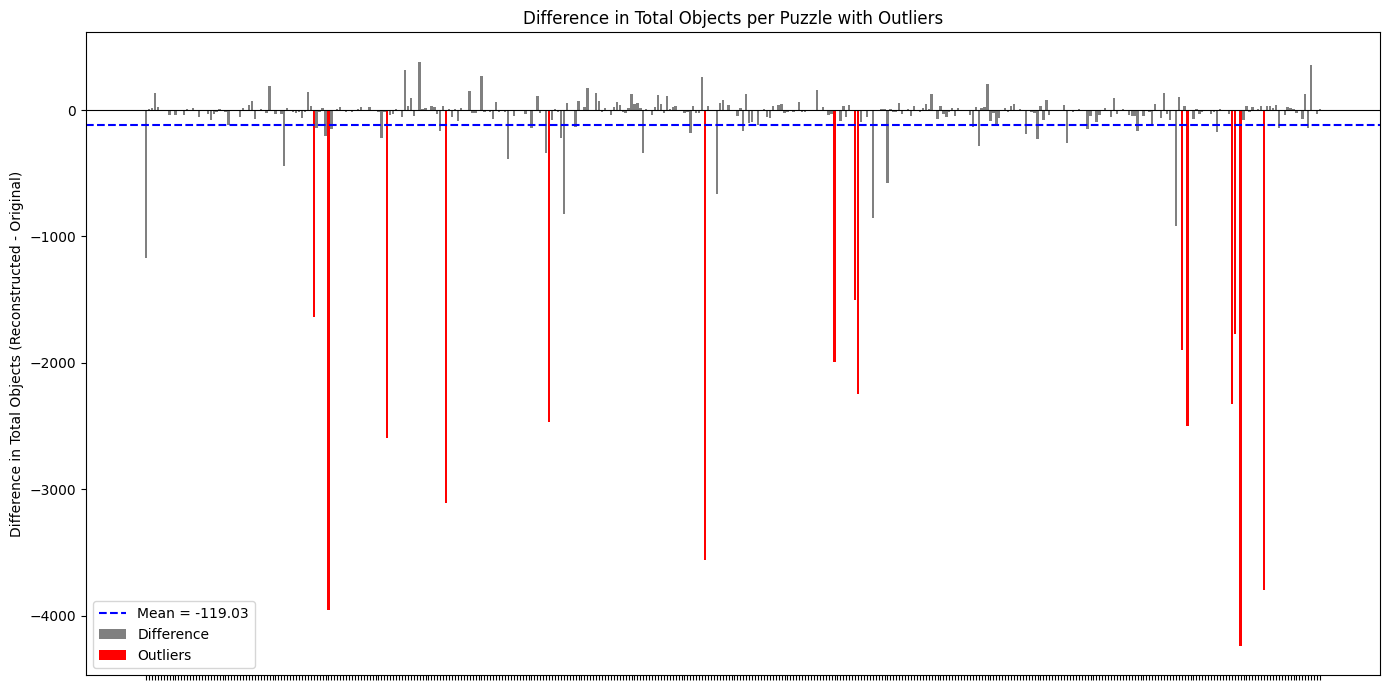

Mean difference: -119.0275
Variance of difference: 291943.5767
Number of outliers: 15 / 400
['319f2597', '4aab4007', 'c663677b', 'ea959feb', '25094a63', '47996f11', 'ca8f78db', 'e66aafb8', '0934a4d8', 'de493100', 'af22c60d', '929ab4e9', 'e95e3d8e', 'f9d67f8b', '981571dc'] outliers in total_objects differences


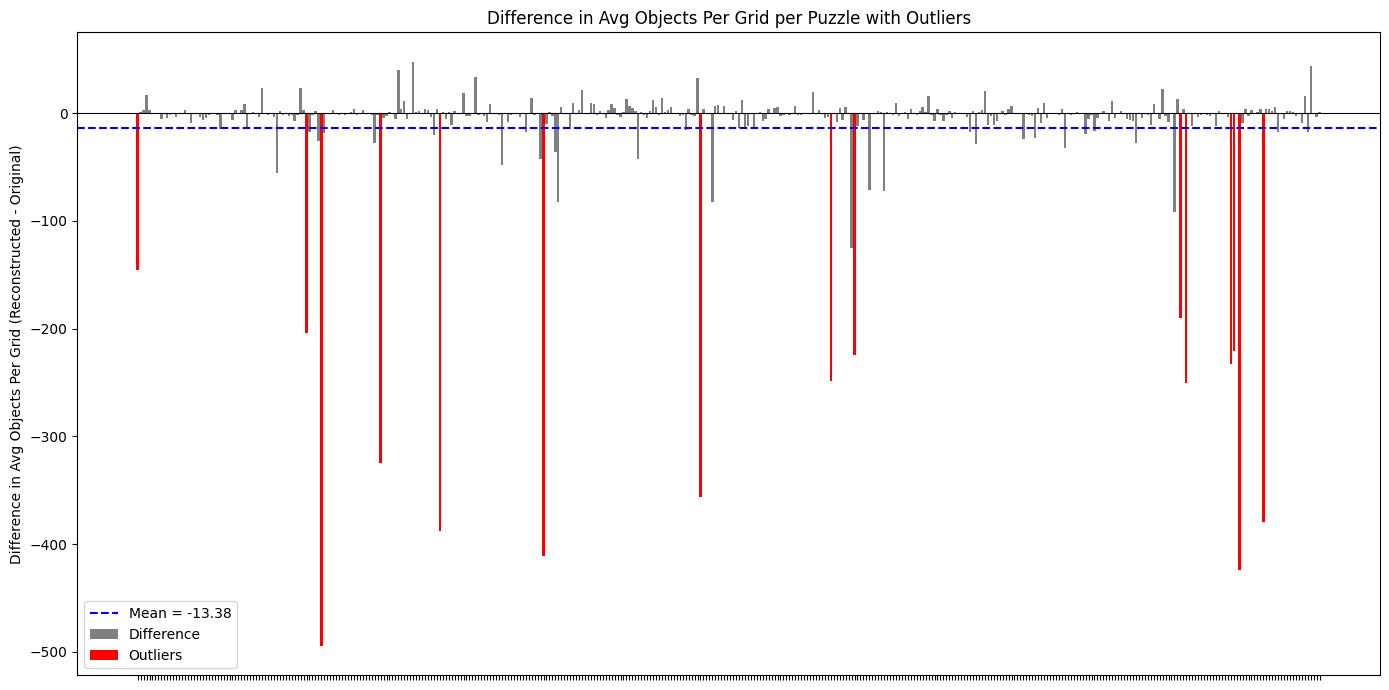

Mean difference: -13.3813
Variance of difference: 3780.6814
Number of outliers: 15 / 400
['1d0a4b61', '319f2597', '4aab4007', 'c663677b', 'ea959feb', '25094a63', '47996f11', 'ca8f78db', '0934a4d8', 'de493100', 'af22c60d', '929ab4e9', 'e95e3d8e', 'f9d67f8b', '981571dc'] outliers in avg_objects_per_grid differences


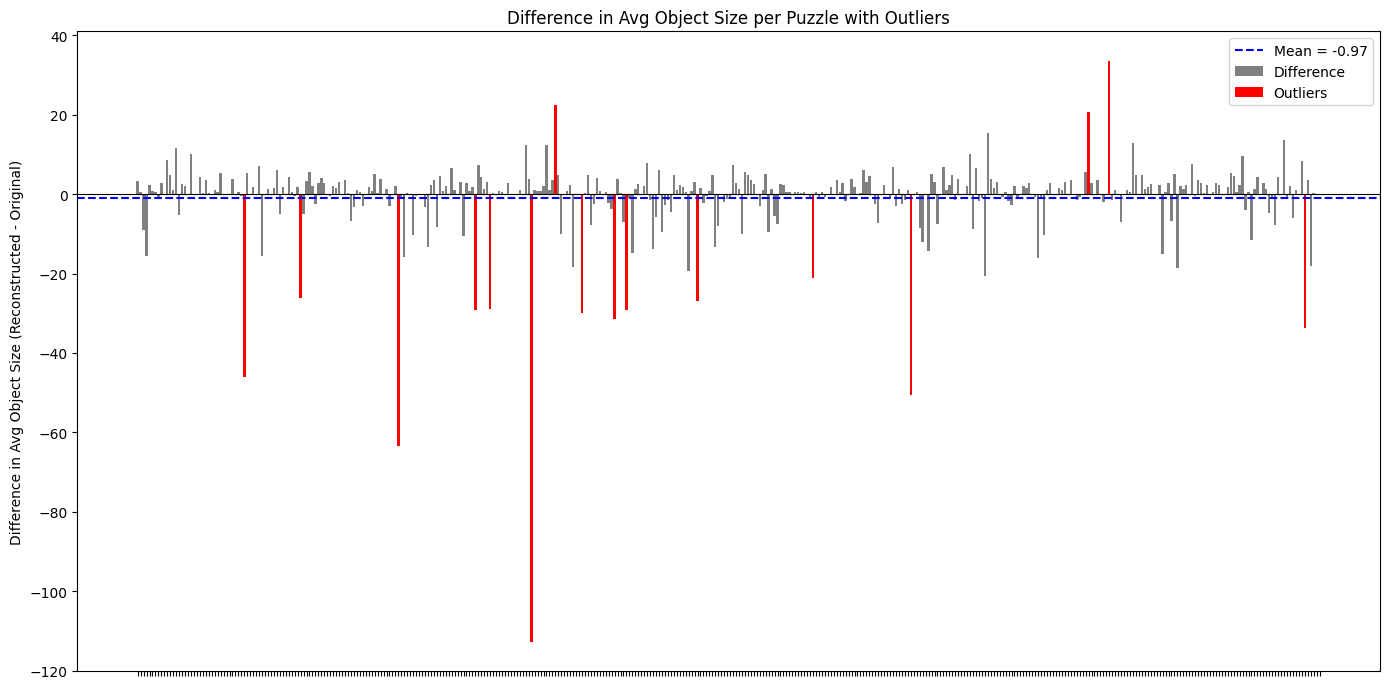

Mean difference: -0.9702
Variance of difference: 100.4895
Number of outliers: 16 / 400
['695367ec', 'fd096ab6', 'aa4ec2a5', 'b9630600', '4364c1c4', 'e57337a4', '4f537728', '40f6cd08', '2f0c5170', 'a3f84088', 'e760a62e', 'e0fb7511', '332efdb3', 'fea12743', 'ba9d41b8', 'a57f2f04'] outliers in avg_object_size differences


In [82]:
def plot_difference_with_stats(df_orig, df_recon, column_name):
    df_merged = df_orig[['puzzle_id', column_name]].merge(
        df_recon[['puzzle_id', column_name]],
        on='puzzle_id',
        suffixes=('_orig', '_recon')
    )
    
    puzzles = df_merged['puzzle_id']
    x = np.arange(len(puzzles))
    
    diff_vals = df_merged[f'{column_name}_recon'] - df_merged[f'{column_name}_orig']
    
    mean_diff = np.mean(diff_vals)
    var_diff = np.var(diff_vals)
    std_diff = np.std(diff_vals)
    
    outlier_mask = np.abs(diff_vals - mean_diff) > 2 * std_diff
    
    # Plot differences
    _, ax = plt.subplots(figsize=(14, 7))
    
    _ = ax.bar(x, diff_vals, color='gray', label='Difference')
    ax.bar(x[outlier_mask], diff_vals[outlier_mask], color='red', label='Outliers')
    
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axhline(mean_diff, color='blue', linestyle='--', label=f'Mean = {mean_diff:.2f}')
    
    column_title = column_name.replace('_', ' ').title()
    ax.set_ylabel(f'Difference in {column_title} (Reconstructed - Original)')
    ax.set_title(f'Difference in {column_title} per Puzzle with Outliers')
    ax.set_xticks(x)
    ax.set_xticklabels([])  # Hide puzzle_id labels
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    outlier_puzzle_ids = puzzles[outlier_mask].tolist()

    print(f"Mean difference: {mean_diff:.4f}")
    print(f"Variance of difference: {var_diff:.4f}")
    print(f"Number of outliers: {np.sum(outlier_mask)} / {len(diff_vals)}")
    return outlier_puzzle_ids

for col in df.columns:
    if col != 'puzzle_id':
        outliers = plot_difference_with_stats(df, df_recon, col)
        print(f'{outliers} outliers in {col} differences')